### Simulation Part 

In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
import numpy as np
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 2
# relative importance of housing consumption and non durable consumption 
alpha = 0.8
# parameter used to calculate the housing consumption 
kappa = 0.3
# depreciation parameter 
delta = 0.025
# housing parameter 
chi = 0.3
# uB associated parameter
B = 2
# # minimum consumption 
# c_bar = 3
# constant cost 
c_h = 20.0
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_b = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1
# constant state variables: Purchase value 250k, down payment 50k, mortgage 200k, interest rate 3.6%,
# 55 payment period, 8.4k per period. One housing unit is roughly 1 square feet. Housing price 0.25k/sf 

# some variables associate with 401k amount
Nt = [np.sum(Pa[t:]) for t in range(T_max-T_min)]
Dt = [np.ceil(((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)) for N in Nt]

# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1, 5, 10, 15, 25, 40, 65, 100, 150, 300, 400,1000])
n_grid_size = len(ns)
# Mortgage amount, * 0.25 is the housing price per unit
Ms = np.array([50, 100, 150, 200, 350])*0.25
M_grid_size = len(Ms)
# Improvement amount 
gs = np.array([0,25,50,75,100])
g_grid_size = len(gs)
points = (ws,ns,Ms,gs)
# housing unit
H = 400
# mortgate rate 
rh = 0.036
# mortgate payment 
m = 3
# housing price constant 
pt = 250/1000
# 30k rent 1000 sf
pr = 30/1000

xgrid = np.array([[w, n, M, g_lag, e, s] 
                            for w in ws
                            for n in ns
                            for M in Ms
                            for g_lag in gs 
                            for e in [0,1]
                            for s in [0,1]
                            ]).reshape((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2,6))

In [3]:
import quantecon as qe
import timeit
from sklearn.neighbors import KNeighborsRegressor as KN
mc = qe.MarkovChain(Ps)

#Vgrid = np.load("Vgrid_i.npy")
cgrid = np.load("cgrid_i.npy")
bgrid = np.load("bgrid_i.npy")
kgrid = np.load("kgrid_i.npy")
igrid = np.load("igrid_i.npy")
qgrid = np.load("qgrid_i.npy")

def action(t, x):
    w, n, M, g_lag, e, s = x
    c = interpn(points, cgrid[:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid[:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid[:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    i = interpn(points, igrid[:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    q = interpn(points, qgrid[:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    return (c,b,k,i,q)

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    w, n, M, g_lag, e, s = x
    if t <= T_R:
        welfare = 5
        return detEarning[t] * earningShock[int(s)] * e + (1-e) * welfare
    else:
        return detEarning[t]

#Define the evolution of the amount in 401k account 
def gn(t, n, x, s_next):
    w, n, M, g_lag, e, s = x
    if t <= T_R and e == 1:
        # if the person is employed, then 5 percent of his income goes into 401k 
        i = 0.05
        n_cur = n + y(t, x) * i
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
    return (1+r_k[int(s), s_next])*n_cur 


def transition(x, a, t, s_next):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, g_lag, e, s = x
    c,b,k,i,q = a
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    M_next = M*(1+rh) - m
    if q == 1:
        g = (1-delta)*g_lag + i
    else:
        g = (1-delta)*g_lag
        
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
    n_next = gn(t, n, x, s_next)
    if t >= T_R:
        e_next = 0
        return [w_next, n_next, M_next, g, s_next, e_next]
    else:
        for e_next in [0,1]:
            x_next.append([w_next, n_next, M_next, g, s_next, e_next])
            prob_next.append(Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(2, 1, p = prob_next)[0]]

In [4]:
'''
    Start with: 
    Ms = 800 * 0.25
    w = 20
    n  = 0
    g_lag = 0
    e = 1
    s = 1
    1000 agents for 1 economy, 100 economies. 
    
    use numpy array to contain the variable change:
    
    wealth, rFund, Mortgage, hImprov, employment, sState, salary, consumption, hConsumption, bond, stock, improve, hPercentage, life. Shape: (T_max-T_min, numAgents*numEcons)
'''
x0 = [20, 0, 80, 0, 1, 1]

numAgents = 1000
numEcons = 500

In [5]:
import random as rd
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcons)]
def simulation(i):
    track = np.zeros((T_max - T_min,14))
    econState = EconStates[i//numAgents]
    alive = True
    x = x0
    for t in range(len(econState)-1):
        if rd.random() > Pa[t]:
            alive = False
        if alive:
            track[t, 0] = x[0]
            track[t, 1] = x[1]
            track[t, 2] = x[2]
            track[t, 3] = x[3]
            track[t, 4] = x[4]
            track[t, 5] = x[5]
            track[t, 6] = y(t,x)
            a = action(t, x)
            track[t, 7] = a[0]
            track[t, 9] = a[1]
            track[t, 10] = a[2]
            track[t, 11] = a[3]
            track[t, 12] = a[4]
            track[t, 13] = 1
            # calculate housing consumption
            if a[4] == 1:
                h = H + (1-delta)*x[3] + a[3]
                Vh = (1+kappa)*h
            else:
                h = H + (1-delta)*x[3]
                Vh = (1-kappa)*(h-(1-a[4])*H)
            track[t, 8] = Vh
            s_next = econState[t+1]
            x = transition(x, a, t, s_next) 
    return track

In [6]:
%%time
pool = Pool()
agentsHistory = pool.map(simulation, list(range(numAgents*numEcons)))
pool.close()

CPU times: user 13.2 s, sys: 7.79 s, total: 21 s
Wall time: 36min 21s


In [7]:
len(agentsHistory)

500000

In [8]:
np.save("agents", np.array(agentsHistory))

In [9]:
agents = np.load("agents.npy")

In [10]:
wealth = np.zeros((T_max-T_min, numAgents*numEcons))
rFund = np.zeros((T_max-T_min, numAgents*numEcons))
Mortgage = np.zeros((T_max-T_min, numAgents*numEcons))
hImprove = np.zeros((T_max-T_min, numAgents*numEcons))
employment = np.zeros((T_max-T_min, numAgents*numEcons))
sState = np.zeros((T_max-T_min, numAgents*numEcons))
salary = np.zeros((T_max-T_min, numAgents*numEcons))
consumption = np.zeros((T_max-T_min, numAgents*numEcons))
hConsumption = np.zeros((T_max-T_min, numAgents*numEcons))
bond = np.zeros((T_max-T_min, numAgents*numEcons))
stock = np.zeros((T_max-T_min, numAgents*numEcons))
improve = np.zeros((T_max-T_min, numAgents*numEcons))
hPer = np.zeros((T_max-T_min, numAgents*numEcons))
life = np.zeros((T_max-T_min, numAgents*numEcons))

In [11]:
def separateAttributes(agents):
    for i in range(numAgents*numEcons):
        wealth[:,i] = agents[i][:,0]
        rFund[:,i] = agents[i][:,1]
        Mortgage[:,i] = agents[i][:,2]
        hImprove[:,i] = agents[i][:,3]
        employment[:,i] = agents[i][:,4]
        sState[:,i] = agents[i][:,5]
        salary[:,i] = agents[i][:,6]
        consumption[:,i] = agents[i][:,7]
        hConsumption[:,i] = agents[i][:,8]
        bond[:,i] = agents[i][:,9]
        stock[:,i] = agents[i][:,10]
        improve[:,i] = agents[i][:,11]
        hPer[:,i] = agents[i][:,12]
        life[:,i] = agents[i][:,13]
separateAttributes(agents)

In [12]:
np.save("wealth", wealth)
np.save("rFund", rFund)
np.save("Mortgage", Mortgage)
np.save("hImprov", hImprove)
np.save("employment", employment)
np.save("sState", sState)
np.save("salary", salary)
np.save("consumption", consumption)
np.save("hConsumption", hConsumption)
np.save("bond", bond)
np.save("stock", stock)
np.save("improve", improve)
np.save("hPer", hPer)
np.save("life", life)

### Summary Plot

In [13]:
wealth = np.load("wealth.npy")
rFund = np.load("rFund.npy")
Mortgage = np.load("Mortgage.npy")
hImprove = np.load("hImprov.npy")
employment = np.load("employment.npy")
sState = np.load("sState.npy")
salary = np.load("salary.npy")
consumption = np.load("consumption.npy")
hConsumption = np.load("hConsumption.npy")
bond = np.load("bond.npy")
stock = np.load("stock.npy")
improve = np.load("improve.npy")
hPer = np.load("hPer.npy")
life = np.load("life.npy")

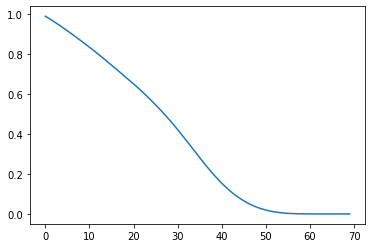

In [14]:
# Population during the entire simulation period
plt.plot(np.mean(life, axis = 1))

In [15]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(69):
        if len(np.where(life[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(life[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(69):
        if len(np.where(life[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(life[i,:] == 1)]))
    return np.array(means)

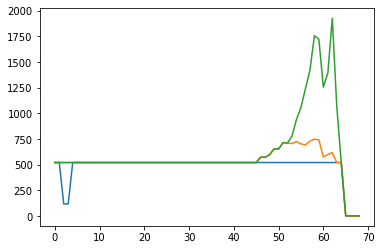

In [16]:
# plot the 0.25, 0.5, 0.75 quantiles of housing consumption 
plt.plot(quantileForPeopleWholive(hConsumption))

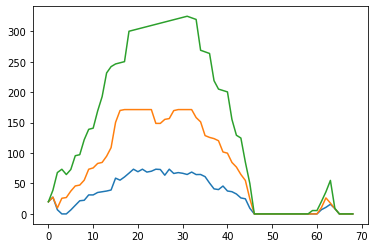

In [17]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(wealth))

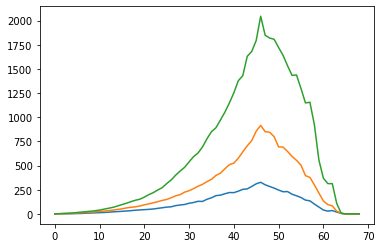

In [18]:
# plot the 0.25, 0.5, 0.75 quantiles of 401k amount 
plt.plot(quantileForPeopleWholive(rFund))

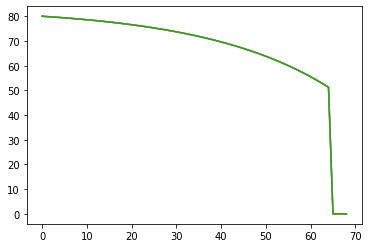

In [19]:
# plot the 0.25, 0.5, 0.75 quantiles of Mortgage amount
plt.plot(quantileForPeopleWholive(Mortgage))

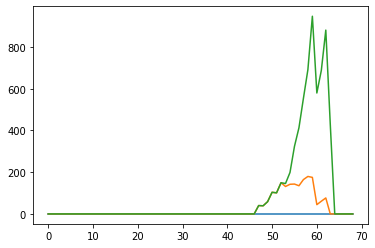

In [20]:
# plot the 0.25, 0.5, 0.75 quantiles of housing improvement
plt.plot(quantileForPeopleWholive(hImprove))

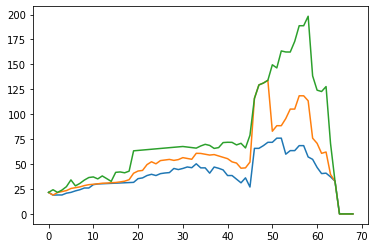

In [21]:
# plot the 0.25, 0.5, 0.75 quantiles of consumption 
plt.plot(quantileForPeopleWholive(consumption))

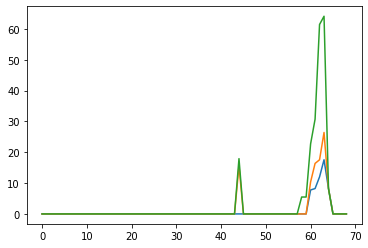

In [22]:
# plot the 0.25, 0.5, 0.75 quantiles of bond
plt.plot(quantileForPeopleWholive(bond))

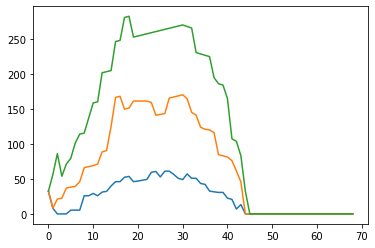

In [23]:
# plot the 0.25, 0.5, 0.75 quantiles of stock
plt.plot(quantileForPeopleWholive(stock))

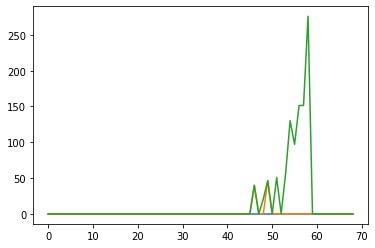

In [24]:
# plot the 0.25, 0.5, 0.75 quantiles of housing improvement at this one episode 
plt.plot(quantileForPeopleWholive(improve))

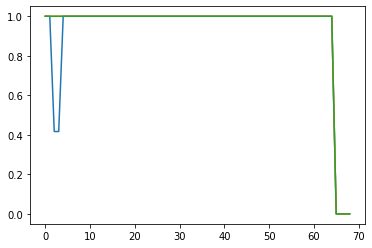

In [25]:
# plot the 0.25, 0.5, 0.75 quantiles of house occupation p, is p == 1 means no renting out 
plt.plot(quantileForPeopleWholive(hPer))

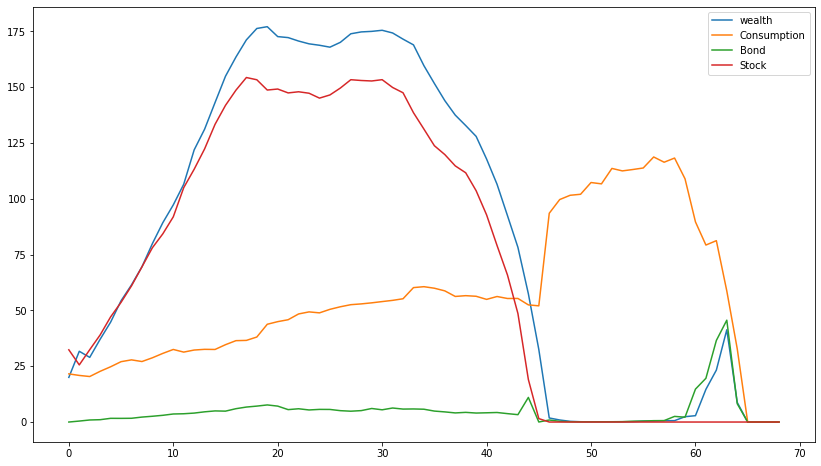

In [26]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(wealth), label = "wealth")
# plt.plot(meanForPeopleWholive(rFund), label = "rFund")
plt.plot(meanForPeopleWholive(consumption), label = "Consumption")
plt.plot(meanForPeopleWholive(bond), label = "Bond")
plt.plot(meanForPeopleWholive(stock), label = "Stock")
#plt.plot(meanForPeopleWholive(rFund), label = "401k")
plt.legend()